In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.notebook import tqdm
from KMlib.metrics import total_score
from KMlib.plot_metrics import plot_loss,plot_test
from KMlib.naive_processing import get_submit_data
from KMlib.processing import pr_scaling,x_scaling,Processer,get_test_data

In [2]:
# change file here
df_rich = pd.read_csv(r'../data/the_rich_r_6.csv',index_col = 0)
df_poor = pd.read_csv(r'../data/the_poor_r_6.csv',index_col = 0)

In [3]:
## get true test value
df = pd.read_csv(r'../data/complete_feature.csv',index_col = 0)
purchase_true = df.loc["2014-08-01":"2014-08-30"].iloc[:, 0]
redeem_true = df.loc["2014-08-01":"2014-08-30"].iloc[:, 1]
df_train = df.loc[:"2014-07-31"]

In [4]:
df_poor_train = df_poor.loc[:"2014-07-31"]
df_rich_train = df_rich.loc[:"2014-07-31"]
df_poor_train = df_poor.loc[:"2014-07-31"]
df_rich_train = df_rich.loc[:"2014-07-31"]
pp_data,prc_data,prt_data,pp_scaler,prc_scaler,prt_scaler = pr_scaling(df_poor_train)
rp_data,rrc_data,rrt_data,rp_scaler,rrc_scaler,rrt_scaler = pr_scaling(df_rich_train)


In [87]:
WINDOW_SIZE =30
BATCH_SIZE = 8
SHUFFLE_BUFFER = 1000
number_pred = 30
number_shift = 1
input_dimension = 3
tf.random.set_seed(7)
np.random.seed(7)
C= Processer(WINDOW_SIZE,BATCH_SIZE,SHUFFLE_BUFFER,number_pred,number_shift,input_dimension)

In [89]:
# poor
pp_tensor_train,pp_tensor_valid = C.get_tensor_dataset(pp_data)
prc_tensor_train,prc_tensor_valid = C.get_tensor_dataset(prc_data)
prt_tensor_train,prt_tensor_valid = C.get_tensor_dataset(prt_data)
## rich
rp_tensor_train,rp_tensor_valid = C.get_tensor_dataset(rp_data)
rrc_tensor_train,rrc_tensor_valid = C.get_tensor_dataset(rrc_data)
rrt_tensor_train,rrt_tensor_valid = C.get_tensor_dataset(rrt_data)

In [90]:

pp_tensor_train

<PrefetchDataset shapes: ((None, 30, 1), (None, 30, 1)), types: (tf.float64, tf.float64)>

### Learning rate

In [26]:
def get_r_model(train, valid,  epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=7,strides=1, padding="causal",activation="relu",input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)), 
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=1e-8)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda x:1e-8 * 10**(x/20))
    model.compile(loss="mae", optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0,validation_data=valid
                        ,callbacks = [lr_decay]
                       )
    return model, history
def get_p_model(train, valid,  epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=7,strides=1, padding="causal",activation="relu",input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)), 
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=False)), 
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(30)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=1e-8)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda x:1e-8 * 10**(x/20))

    model.compile(loss="mae", optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0,validation_data=valid
                        ,callbacks = [lr_decay]
                       )
    return model, history

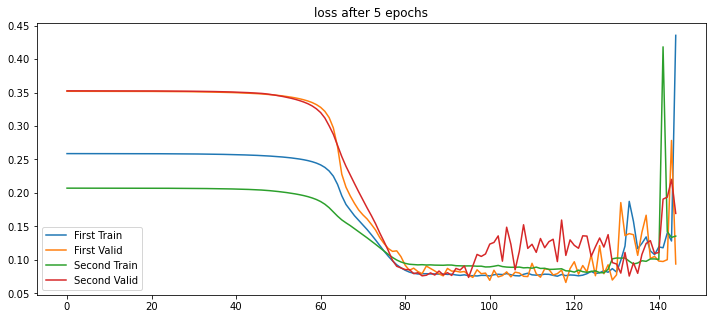

In [27]:
30# p
tf.keras.backend.clear_session()
epochs = 150
pp_model,pp_history =get_p_model(pp_tensor_train ,pp_tensor_valid,epochs = epochs)
tf.keras.backend.clear_session()
rp_model,rp_history =get_p_model(rp_tensor_train ,pp_tensor_valid,epochs = epochs)
plot_loss(pp_history, rp_history)

(1e-08, 0.1, 0.0, 0.5)

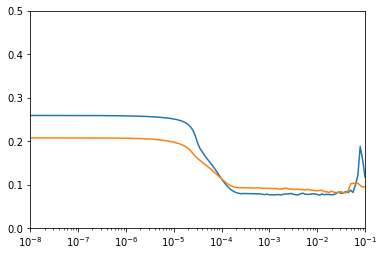

In [32]:
plt.semilogx(pp_history.history["lr"], pp_history.history["loss"])
plt.semilogx(rp_history.history["lr"], rp_history.history["loss"])
plt.axis([1e-8, 1e-1, 0, 0.5])

## Model developing part

In [91]:
def get_r_model(train, valid,  epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3,strides=1, padding="causal",activation="tanh",input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True), 
    tf.keras.layers.LSTM(32, return_sequences=True), 
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1),
    ])
    optimizer = tf.keras.optimizers.Adam(lr=1e-4)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda x:1e-4 * 10**(-x/1000))
    model.compile(loss="mae", optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0,validation_data=valid
#                         ,callbacks = [lr_decay]
                       )
    return model, history
def get_p_model(train, valid,  epochs):
    model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(filters=32, kernel_size=3,strides=1, padding="causal",activation="relu",input_shape=[WINDOW_SIZE, 1]),
    tf.keras.layers.LSTM(32, return_sequences=True), 
    tf.keras.layers.LSTM(32, return_sequences=True),   
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.Adam(lr=1e-4)
    lr_decay = tf.keras.callbacks.LearningRateScheduler(lambda x:1e-4 * 10**(-x/1000))
    model.compile(loss="mae", optimizer=optimizer)
    history = model.fit(train, epochs=epochs, verbose=0, validation_data=valid
#                         ,callbacks = [lr_decay]
                       )
    return model, history

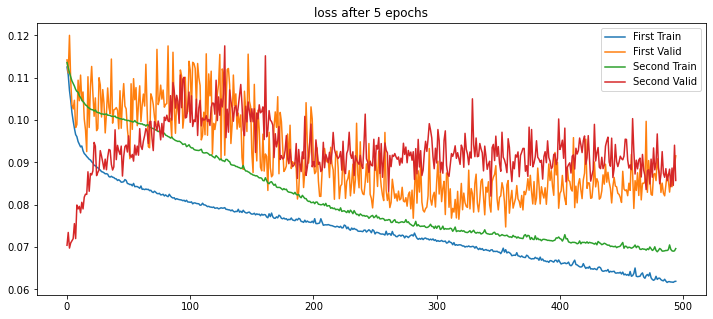

In [92]:
tf.keras.backend.clear_session()
tf.random.set_seed(7)
np.random.seed(7)
epochs = 500
pp_model,pp_history =get_p_model(pp_tensor_train ,pp_tensor_valid,epochs = epochs)
tf.keras.backend.clear_session()
rp_model,rp_history =get_p_model(rp_tensor_train ,rp_tensor_valid,epochs = epochs)
plot_loss(pp_history, rp_history)

In [2]:
plt.plot(pp_history.history['val_loss'][25:])
plt.plot(rp_history.history['val_loss'][25:])

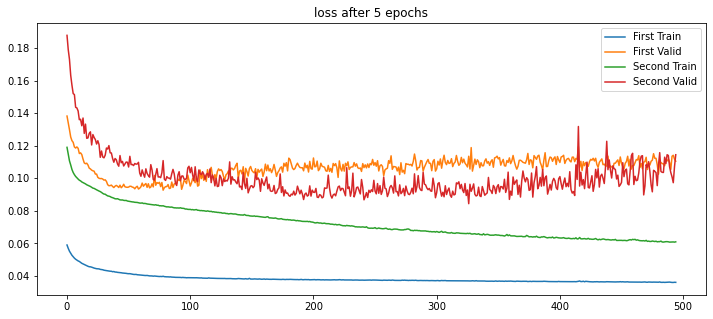

In [94]:
tf.keras.backend.clear_session()
epochs = 500
prc_model,prc_history =get_r_model(prc_tensor_train,prc_tensor_valid,epochs = epochs)
tf.keras.backend.clear_session()
prt_model,prt_history =get_r_model(prt_tensor_train,prt_tensor_valid,epochs = epochs)
plot_loss(prc_history,prt_history)

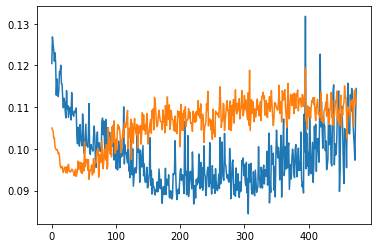

In [95]:
plt.plot(prt_history.history['val_loss'][25:])
plt.plot(prc_history.history['val_loss'][25:])

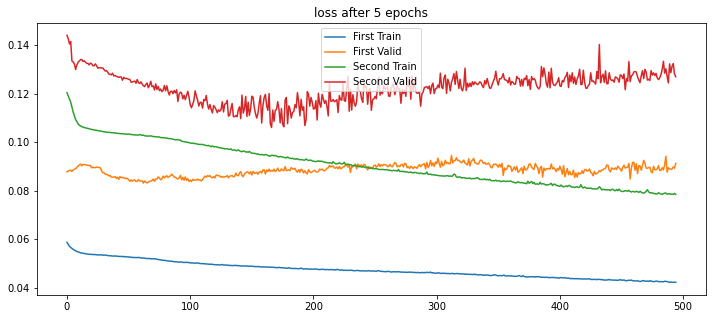

In [96]:
epochs = 500
tf.keras.backend.clear_session()
rrc_model,rrc_history =get_r_model(rrc_tensor_train,rrc_tensor_valid,epochs = epochs)
tf.keras.backend.clear_session()
rrt_model,rrt_history =get_r_model(rrt_tensor_train,rrt_tensor_valid,epochs =epochs)
plot_loss(rrc_history,rrt_history)

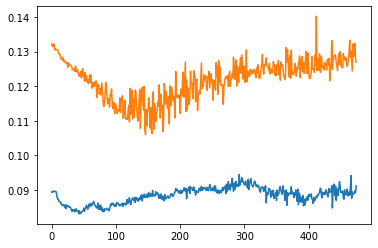

In [97]:
plt.plot(rrc_history.history['val_loss'][25:])
plt.plot(rrt_history.history['val_loss'][25:])

In [98]:
# get test set data
# df_poor_test = df_poor[-WINDOW_SIZE:] # for TIANCHI
# df_rich_test = df_rich[-WINDOW_SIZE:] # for TIANCHI
df_poor_test = df_poor_train[-WINDOW_SIZE:] # for Project
df_rich_test = df_rich_train[-WINDOW_SIZE:] # for Project
pp_test,prc_test,prt_test = get_test_data(df_poor_test,pp_scaler,prc_scaler,prt_scaler)
rp_test,rrc_test,rrt_test = get_test_data(df_rich_test,rp_scaler,rrc_scaler,rrt_scaler)

In [99]:
pp_pred = pp_scaler.inverse_transform(pp_model.predict(pp_test[np.newaxis,...]).reshape(1,30)).reshape(30,)
prc_pred = prc_scaler.inverse_transform(prc_model.predict(prc_test[np.newaxis,...]).reshape(1,30)).reshape(30,)
prt_pred = prt_scaler.inverse_transform(prt_model.predict(prt_test[np.newaxis,...]).reshape(1,30)).reshape(30,)
rp_pred = rp_scaler.inverse_transform(rp_model.predict(rp_test[np.newaxis,...]).reshape(1,30)).reshape(30,)
rrc_pred = rrc_scaler.inverse_transform(rrc_model.predict(rrc_test[np.newaxis,...]).reshape(1,30)).reshape(30,)
rrt_pred = rrt_scaler.inverse_transform(rrt_model.predict(rrt_test[np.newaxis,...]).reshape(1,30)).reshape(30,)

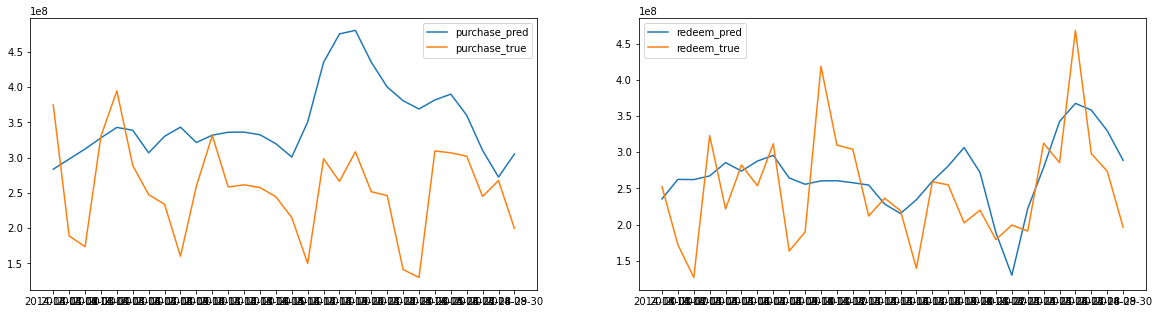

72.13460565915

In [100]:
purchase_true = df.loc["2014-08-01":"2014-08-30"].iloc[:, 0]
redeem_true = df.loc["2014-08-01":"2014-08-30"].iloc[:, 1]
purchase_pred = pp_pred + rp_pred
redeem_pred = rrc_pred + rrt_pred + prt_pred + prc_pred
plot_test(purchase_pred,purchase_true,redeem_pred,redeem_true)
total_score(purchase_pred,purchase_true,redeem_pred,redeem_true)